# Homework #6: Solutions
## Descent Algorithms for Optimization

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2020**

**Name:**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
### Import basic libraries
import time
import numpy as np
import pandas as pd
import sklearn as sk
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Problem Description: Minimizing the Cost of a Construction Project

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by

$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$

Read the data contained in `HW5_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. In this problem, we find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part I: Cost minimization with descent algorithms

1. (**Visualizing the Optimization Landscape**) Using level curves (see Lab #1) and a 3D plot, visually verify that at $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is globally minimized.<br><br>

2. (**Gradient Descent**) Implement gradient descent for minimizing the **average** of $L$ over the locations given in the data, using the learning rate of 1.0 and initialization of $\lambda_1 = 2, \lambda_2 = 1$. Visually determine if your algorithm has converged. 

  **Hint:** You may need to visualize the behavior over the total number of iterations as well as its value over the last couple of hundreds of iterations to check for convergence.<br><br>

3. (**Stochastic Gradient Descent**) Implement stochastic gradient descent for minimizing the **average** of $L$ over the locations in the mini-batch, using the learning rate of 1.0 and initialization of $\lambda_1 = 2, \lambda_2 = 1$ and mini-batch size of 1. Visually determine if your algorithm has converged.

  **Hint:** You may need to visualize the behavior over the total number of iterations as well as its value over the last couple of hundreds of iterations to check for convergence.<br><br>

4. (**How to Compare GD and SGD Fairly**) Argue that minimizing the average loss over the locations is equivalent to minimizing the net loss. However, minimizing the average loss makes it possible to compare gradient descent and stochastic gradient descent on equal terms. Explain why this is true.<br><br>

5. (**Comparing the Efficiency of GD and SGD**) Compute the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.

  Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (in this case, you know the true global optima so you can check the norm $\|(\lambda_1, \lambda_2) - (\lambda_1^{\text{true}}, \lambda_2^{\text{true}})\|_2$ ). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.<br><br>

6. (**Comparing Sensitivity of GD and SGD to Learning Rate**) Compare the performance of both gradient descent methods for the following learning rates: 1000, 100, 1., 0.1. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of each algorithm. In particular, which algorithm is more sensitve to the learning rate?

  **Hint:** You may need to visualize the behavior over the total number of iterations as well as its value over the first and last couple of hundreds of iterations separately to isolate trends.<br><br>


7. (**Comparing Sensitivity of GD and SGD to Initialization**) Document the behaviour of your two descent algorithms for the following starting points, and for stepsizes of 10 and 50:
  - $(\lambda_1, \lambda_2) = (-2.47865, 0)$
  - $(\lambda_1, \lambda_2) = (-3, 0)$
  - $(\lambda_1, \lambda_2) = (-5, 0)$
  - $(\lambda_1, \lambda_2) = (-10, 0)$

  Based on your visualization of the graph/contour map of the lost function as well as the visualization of the loss function during descent, explain what is happening to your descent algorithms for each initialization.
  
**Solutions:**  

1. [Visualizing Our Loss Function](#viz)

4. [Implementation: Gradient Descent](#implement_grad)

5. [Implementation: Stochastic Gradient Descent](#implement_rand)

6. [Comparison: Gradient Descent vs Stochastic Gradient Descent](#compare)
  1. [Speed](#speed)
  2. [Sensitivity to Stepsize](#stepsize)
  3. [Sensitivity to Initialization](#init)

<a id='viz'></a>
### Visualizing Our Loss Function
Given our loss function $L(x, y, \lambda_1, \lambda_2)$ at the coordinate $(x, y)$ and for the set of parameter settings $(\lambda_1, \lambda_2)$, the ***total loss*** over the entire set of coordinates in the data is
\begin{aligned}
\mathrm{Total Loss} = \sum_{i=1}^N L(x_i, y_i, \lambda_1, \lambda_2) &= \sum_{i=1}^N\left[0.000045\lambda_2^2 y_i - 0.000098\lambda_1^2 x_i + 0.003926\lambda_1 x_i\exp\left\{\left(y_i^2 - x_i^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\right]\\
&= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \sum_{i=1}^N x_i \exp\left\{\left(y_i^2 - x_i^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
\end{aligned}
where $N$ is total number of coordinates in our data set. Now, since the pipes are being laid down in a particular geometric pattern, namely along a hyperbola described by $y^2 - x^2 = -0.1$, we can further simplify the above as:
\begin{aligned}
\mathrm{Total Loss} = \sum_{i=1}^N L(x_i, y_i, \lambda_1, \lambda_2) &= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \sum_{i=1}^N x_i \exp\left\{\left(y_i^2 - x_i^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\\
&= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \sum_{i=1}^N x_i \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\\
&= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^N x_i.
\end{aligned}
In `python`, we would write the above as
```
total_loss = 0.000045 * lambda_2**2 * y.sum() - 0.000098 * lambda_1**2 * x.sum() + 0.003926 * lambda_1 * x.sum() * np.exp(-0.1 * (lambda_1**2 + lambda_2**2))
```

Now, our task can be stated in a straightforward fashion: we wish to find values of $\lambda_1$ and $\lambda_2$ such that the total loss is minized for our set of coordinates.

Now before running ***any*** optimization algorithms on our objective function, we must do some exploration of our function, either by analysis or visualization! This step is important for the following reasons:

1. iteratively following the gradient (the direction of maximum increase or decrease in the objective function at a point) ***does not*** guarantee that you will end in a global maximum or minimum. In fact, if your function has local maxima, local minima or saddle points (at which the gradient is zero - these are called stationary points), your gradient descent may very well become trapped at these points. In this sense, where you initialize your gradient descent algorithm becomes very important. Some initializations will lead you to an undesirable stationary point, while others will lead you to your global maximum or minimum. 

2. analytical, numerical or visual explorations of your function can help you determine appropriate step sizes for your descent algorithms (would $\eta = 0.001$ be appropriate or $\eta=1000$?).

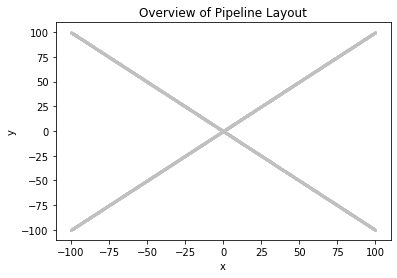

In [2]:
#Visualization of the data - what does the pipeline look like?
x, y = np.genfromtxt('HW5_data.csv', delimiter=',')

plt.scatter(x, y, color='silver', s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Overview of Pipeline Layout')
plt.show()

In [3]:
x_sum = x.sum()
y_sum = y.sum()
N = len(x)

#define total loss
L = lambda l1, l2, x, y: 0.000045 * l2**2 * y.sum() - 0.000098 * l1**2 * x.sum() + 0.003926 * x.sum() * l1 * np.exp(-0.1 * (l1**2 + l2**2))

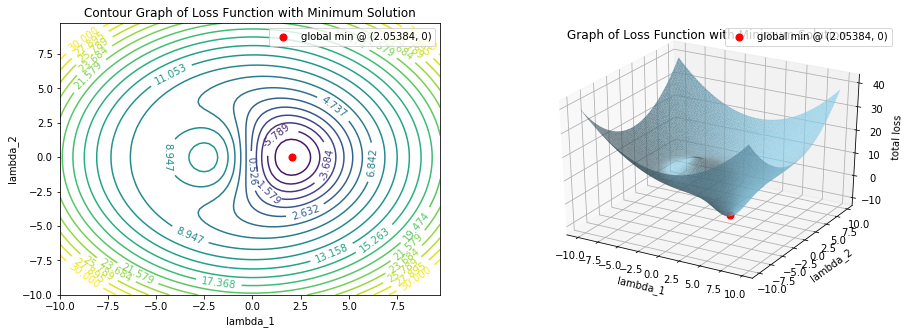

In [4]:
#cover the domain of the pdf with a grid and get the coordinates of the grid vertices
delta = 0.25
l1 = np.arange(-10, 10, delta)
l2 = np.arange(-10, 10, delta)
l1, l2 = np.meshgrid(l1, l2)

loss = L(l1, l2, x, y)

fig = plt.figure(figsize=(15, 5))


#plot contour map of pdf with data in R^2 (Cartesian plane)
ax1 = fig.add_subplot(121) 
contour = ax1.contour(l1, l2, loss, levels=np.linspace(-10, 30, 20))
ax1.scatter([2.05384], [0], color='red', s=50, label='global min @ (2.05384, 0)')
ax1.clabel(contour, inline=1, fontsize=10)
ax1.set_title('Contour Graph of Loss Function with Minimum Solution')
ax1.set_xlabel('lambda_1')
ax1.set_ylabel('lambda_2')
ax1.legend(loc='best')

#plot 3D suface of pdf in R^3
ax2 = fig.add_subplot(122, projection='3d') 
ax2.plot_trisurf(l1.flatten(), l2.flatten(), loss.flatten(), linewidth=0.2, antialiased=True, color='skyblue', alpha=0.8)
ax2.scatter([2.05384], [0], [L(2.05384, 0, x, y)], color='red', s=50, label='global min @ (2.05384, 0)')
ax2.set_xlabel('lambda_1')
ax2.set_ylabel('lambda_2')
ax2.set_zlabel('total loss')
ax2.set_title('Graph of Loss Function with Minimum Solution')
ax2.legend(loc='best')

plt.show()

From the above, we see that the total loss is minimized at $(\lambda_1, \lambda_2) = (2.05384, 0)$. We leave to you to find the other points of interest in the parameter space (it is important that you do!). 

In [5]:
print('The minumum total cost:', L(2.05384, 0, x, y))

The minumum total cost: -9.934104025304476


**Disclaimer**: A negative total is not very interpretable from a business perspective but this is what we are working with.

<a id="implement_grad"></a>
### Implementation: Gradient Descent

We first calculate the gradient of our total loss function,
\begin{aligned}
\frac{\partial TotalLoss}{\partial \lambda_1} =&  -2 * 0.000098\lambda_1 \sum_{i=1}^{N} x_i + 0.003926 \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^{N} x_i \\
& - 0.1 * 0.003926 * 2 * \lambda_1^2 * \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^{N} x_i\\
\frac{\partial TotalLoss}{\partial \lambda_2} =&\,  2 * 0.000045\lambda_2^2 \sum_{i=1}^{N} y_i - 0.1 * 2 *  0.003926\lambda_1  \lambda_2 \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^{N} x_i.\\
\nabla TotalLoss =&\, \left[\frac{\partial TotalLoss}{\partial \lambda_1}, \frac{\partial TotalLoss}{\partial \lambda_2} \right].
\end{aligned}

In [6]:
#The gradient of the total loss function
grad = lambda l1, l2, x, y: np.array([-0.000098 * 2 * l1 * x.sum() 
                                      + 0.003926 *  x.sum() * np.exp(-0.1 * (l1**2 + l2**2)) 
                                      - 0.003926 * 2 * 0.1 *  x.sum() * l1**2 * np.exp(-0.1 * (l1**2 + l2**2)), 
                                      2 * 0.000045 * l2 * y.sum() 
                                      - 0.1 * 2* 0.003926 *  x.sum() * l1 * l2 * np.exp(-0.1 * (l1**2 + l2**2))])

A note on the correct loss function to use:

> **Total Loss or Average Loss?** If we're just interested in minimizing the loss, minimizing total loss is equivalent to minimizing average loss. This is because
$$
Average Loss = \frac{1}{N} TotalLoss
$$
Clearly, since $N$ is a constant, when total loss is minimized then average loss is minimized (and vice versa). However, if we are interested in comparing the performance of gradient descent with that of stochastic gradient descent, we need to find a loss function that facilitates a fair comparison. 

> If we use the total loss for both descent algorithm, then the gradient for gradient descent will tend to be much larger (since in gradient descent, we sum over the entire dataset to compute the gradient, whereas in stochastic gradient descent, we use only one pair of coordinates to compute the gradient). Larger gradients will tend to yield larger steps in our descent, which, in turn, will tend to result in faster convergence. 

> To be fair, we will use the ***average loss function*** for both gradient descent and stochastic gradient descent. This make sense semantically as well, the loss funtion averaged over the entire data set is the expected loss for a single coordinate, whereas evaluating the loss function at a random coordinate is a way of approximating the expected loss for a single coordinate. 

> Coding wise, we just need to multiply the total cost function and the gradient function we've defined by 1/N to turn them into averages.

A note on the correct stopping condition to use:

> **Average/Total loss or lambdas?** In this problem, we know the precise location of the global minimum: (2.05384, 0), and we know the minimum total cost: -9.9341040253. So should we stop when we are sufficiently close to the optimal parameters, $(2.05384, 0)$, or should we stop when we are sufficiently close to the minimum total cost? Well, the difference is not significant and in general you can choose to use either as your stopping condition. However, since evaluating the cost at each step of the gradient descent (which involves suming over your entire dataset) is one extra computation expense, it might be more efficient to use distance to the optimal parameters as your stopping condition. 

> That is, we stop our descent when
$$
\| [ lambda_1,  lambda_2] - [ 2.05384, 0 ] \|_2 < 1e^{-3}
$$
where $\| \cdot \|_2$ is the $\ell_2$ norm or the Euclidean distance.

In [7]:
#Gradient Descent
def gradient_descent(x, y, lambdas_init, init_shuffle=False, step_size=0.001, maxsteps=None, precision=1e-3):
    
    lambdas = lambdas_init
    history = [lambdas] # to store all parameters
    grad_norms = [np.linalg.norm(grad(lambdas[0], lambdas[1], x, y) * 1. / N)]
    counter = 0

    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]

    #Do descent while stopping condition not met
    while np.linalg.norm(history[-1] - np.array([2.05384, 0])) > precision:
        #get gradient of average loss function
        gradient = grad(lambdas[0], lambdas[1], x, y) * 1. / N
        #take one step in the gradient direction
        lambdas = lambdas -  step_size * gradient 
        #add our new parameters to the history
        history.append(lambdas)
        #add the norm of the gradient to our list of norms
        grad_norms.append(np.linalg.norm(gradient))
        #tick off one more step
        counter +=1
        
        #if we've hit maximum steps allowed, stop!
        if maxsteps is not None:
            if counter == maxsteps:
                break
        
    return history, grad_norms

time to compute one gradient:  0.0002372264862060547
how many iters:  43545
final cost: -9.93410274854933
precision to actual param: 0.000999868898540722


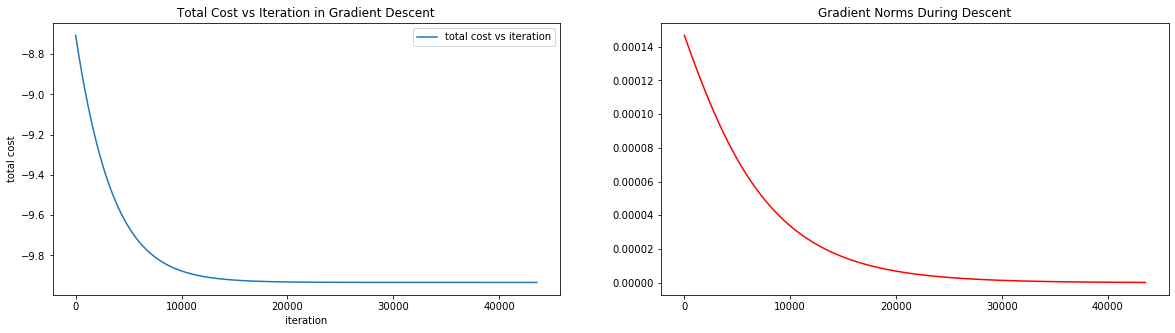

In [8]:
lambdas_init = [2, 1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x, y) * 1./len(x)
end = time.time() 

history, grad_norms_gd = gradient_descent(x, y, lambdas_init, step_size=1., maxsteps=100000)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)

print('time to compute one gradient: ', end - start)
print('how many iters: ', len(history))
print('final cost:', costs[-1])
print('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(range(len(costs)), costs, label='total cost vs iteration')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('total cost')
ax[0].set_title('Total Cost vs Iteration in Gradient Descent')
ax[0].legend(loc='best')

ax[1].plot(range(len(costs)), grad_norms_gd, color='red')
ax[1].set_title('Gradient Norms During Descent')
plt.show()

We see that we are within tolerance of our optimal parameters after 43,545 steps in the gradient descent algorithm. From the visualization of the total cost versus iteration, we see that initially we were making large updates to our parameters (the total cost was changing quickly), but towards the end the updates to our parameters became smaller and smaller (the total cost was not changing very much from iteration to iteration). This is expected, as the gradient around the global minimum in our case should be close to zero, resulting in very small step-sizes in our descent.

<a id="implement_rand"></a>
### Implementation: Stochastic Gradient Descent

The algorithm for Stochastic Gradient Descent is nearly identical to gradient descent, except for the fact that when we compute the gradient, we feed the gradient function a single coordinate rather than the entire dataset. Furthermore, we make multiple passes through the data, randomizing the dataset at the beginning each time.

In [9]:
#Stochastic Gradient Descent
def sgd(x, y, lambdas_init, init_shuffle=False, step_size=0.001, max_epochs=1, precision=1e-3, output=True):
    lambdas = lambdas_init
    history = [lambdas] # to store all thetas
    grad_norms = [np.linalg.norm(grad(lambdas[0], lambdas[1], x, y) * 1. / N)]
    counter = 0
    epochs = 0
    i = 0 #index
        
    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]    
    
    #run through the data in multiple passes
    for epoch in range(max_epochs):
        #for each data point, compute the gradient and make an update to our parameters
        if output == True:
            print('epoch: ', epoch)
        for i in range(N):
            #get gradient of average loss function
            gradient = grad(lambdas[0], lambdas[1], x[i], y[i])
            #take one step in the gradient direction
            lambdas = lambdas -  step_size * gradient
            #add our new parameters to the history
            history.append(lambdas)   
            #add the norm of the gradient to our list of norms
            grad_norms.append(np.linalg.norm(gradient))
            
            if np.linalg.norm(np.array(lambdas) - np.array([2.05384, 0])) < precision:
                return history, epoch, grad_norms
            elif np.any(np.isnan(lambdas)):
                return history[:-1], epoch, grad_norms
        
        #shuffle the data for the next pass thru
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]
    
    return history, max_epochs, grad_norms

epoch:  0
****************************
no initial random shuffling
****************************
time to compute one gradient:  0.00010991096496582031
how many iters:  15868
final loss: -9.934102852275833
precision to actual param: 0.0009584050556876609


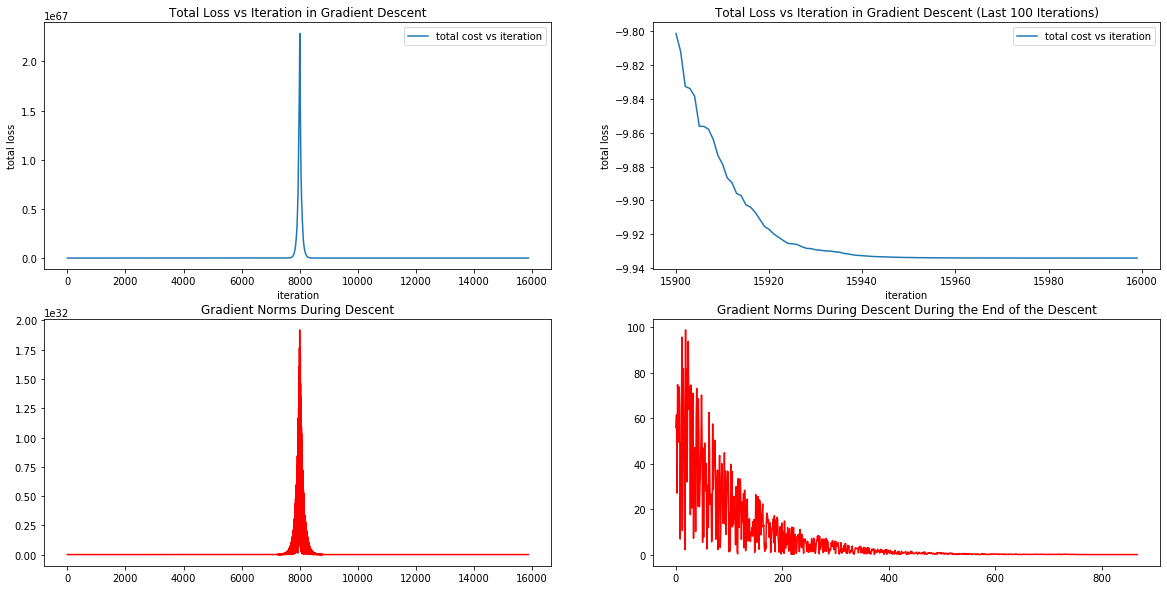

In [10]:
lambdas_init = [2, 1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch, grad_norms_sgd = sgd(x, y, lambdas_init, init_shuffle=False, step_size=1., max_epochs=8)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print('****************************')
print('no initial random shuffling')
print('****************************')
print('time to compute one gradient: ', end - start)
print('how many iters: ', len(history))
print('final loss:', costs[-1])
print('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(np.arange(len(costs[-100:])) + N - 100, costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')

ax3.plot(range(len(costs)), grad_norms_sgd, color='red')
ax3.set_title('Gradient Norms During Descent')

ax4.plot(range(len(costs[15000:])), grad_norms_sgd[15000:], color='red')
ax4.set_title('Gradient Norms During Descent During the End of the Descent')
plt.show()

We see that we are within tolerance of our optimal parameters after 15,868 steps (versus the 43,545 steps it takes gradient descent) in the stochastic gradient descent algorithm. From the visualization of the total loss versus iteration, we see that during our descent, we headed (around iteration number 8,000) in the direction which ***increased*** total cost! But how can this happen? 

Recall that in stochastic gradient descent, we are stepping in the direction that minimizes the loss function for just **one** data point rather than the direction that minimized the loss over the entire dataset. Clearly, pursuing local, short term gains does not lead you down the same path as pursuing global, long term gains. Thus, descending in the direction that descreases the loss for one data point can often lead to an increase the loss over the entire dataset.

Interestingly enough, although our total loss spiked around iteration 8,000, our stochastic gradient descent was able to find the global minimum in a shorter total number of iterations! That is, sometimes the quickest way down hill lies beyond a big climb!

In contrast, gradient descent is typically incapable of finding paths along which the total cost rises. That is, the total cost is expected to decrease form one iteration to the next.

Another thing to note is that the gradient norms of SGD tend to be quite large compared with those of gradient descent. While it's not always good to have a large gradient norm, if the steps taken by a descent algorithm are towards a good direction, then large steps can lead to faster convergence.

epoch:  0
****************************
with initial random shuffling
****************************
time to compute one gradient:  0.0001728534698486328
how many iters:  751
final loss: -9.93410281502612
precision to actual param: 0.0009734993716266635


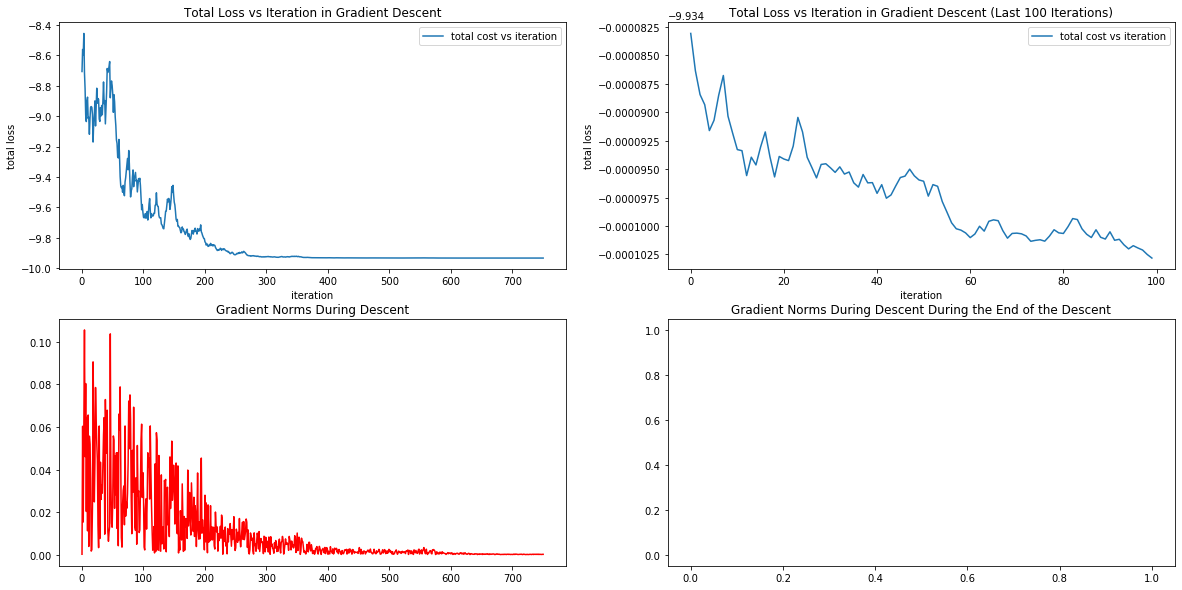

In [11]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch, grad_norms_sgd = sgd(x, y, lambdas_init, init_shuffle=True, step_size=1., max_epochs=8)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print('****************************')
print('with initial random shuffling')
print('****************************')
print('time to compute one gradient: ', end - start)
print('how many iters: ', len(history))
print('final loss:', costs[-1])
print('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')

ax3.plot(range(len(costs)), grad_norms_sgd, color='red')
ax3.set_title('Gradient Norms During Descent')

ax4.plot(range(len(costs[2500:])), grad_norms_sgd[2500:], color='red')
ax4.set_title('Gradient Norms During Descent During the End of the Descent')
plt.show()

We see that we are within tolerance of our optimal parameters after 1,990 steps (versus the 43,545 steps it takes gradient descent) in the stochastic gradient descent algorithm. From the visualization of the total loss versus iteration, we see that, with an initial shuffling of the data, the path stochastic gradient descent takes to the optimal solution is even more erratic. We are taking paths along which the total loss rises and drops before finally stabilizing somewhat around the optimal total loss of -9.93410279384. 

Again, the gradient norms of SGD tend to be quite large compared with those of gradient descent. Again, it's not always good to have a large gradient norm, but in this case, we see that the steps taken by sgd are always towards the direction of the global min, thus the large steps lead to faster convergence.

When we examing the total loss for the last 100 iterations, we see that stochastic gradient descent is ocillating around the optimal loss. This behaviour can be worrisome if we need to obtain a higher precision solution - it's possible that stochastic gradient descent will never fall within the required tolerance.

<a id="compare"></a>
### Comparison: Gradient Descent vs Stochastic Gradient Descent
<a id='speed'></a>
#### Speed:
We see that it takes 0.000573873519897 seconds to compute one gradient for gradient descent, while it takes around 0.000241994857788 seconds to compute one gradient for stochastic gradient descent. This is expected. We expect that computing gradients for gradient descent can take longer, given that we must perform operations on the entire set of data. However, since our dataset is relatively small and our operations (sums) are relatively light weight, the difference between these two gradient computations is minute. 

However, this will not always be the case (i.e. our data will not always be small, and the operations required to compute the gradient will not always be simple)! For example, you can try to perform gradient descent in your Long Form Homework #1 and see how that will change your training time.

So is Stochastic Gradient Descent a faster algorithm? To answer this question rigorously and productively, we must decompose our notion of fast in two ways:

1. the time it takes to compute one gradient
2. the number of steps it takes to converge to an acceptable solution

We've already addressed the difficulty of computing the gradient over the entire dataset - in this case, stochastic gradient descent is the "faster" algorithm. In our case stochastic gradient descent found the global optimum in fewer iterations. However, this is an exception. We can already see, from our visualizations, that stochastic gradient descent can take paths through the parameter space that increases total cost, and it can have oscillating behaviour when it approaches the global optima. In fact, the erratic paths SGD takes can often lead to slow convergence and the algorithm can easily fail to converge at all (i.e. never being able to achieve a certain degree to accuracy). 

<a id='stepsize'></a>
#### Sensitivity to Stepsize:
So how does a change in step size affect the performance of stochastic gradient descent? We will run SGD for various stepsize, each time testing the step size with an initial randomization of the data and without.

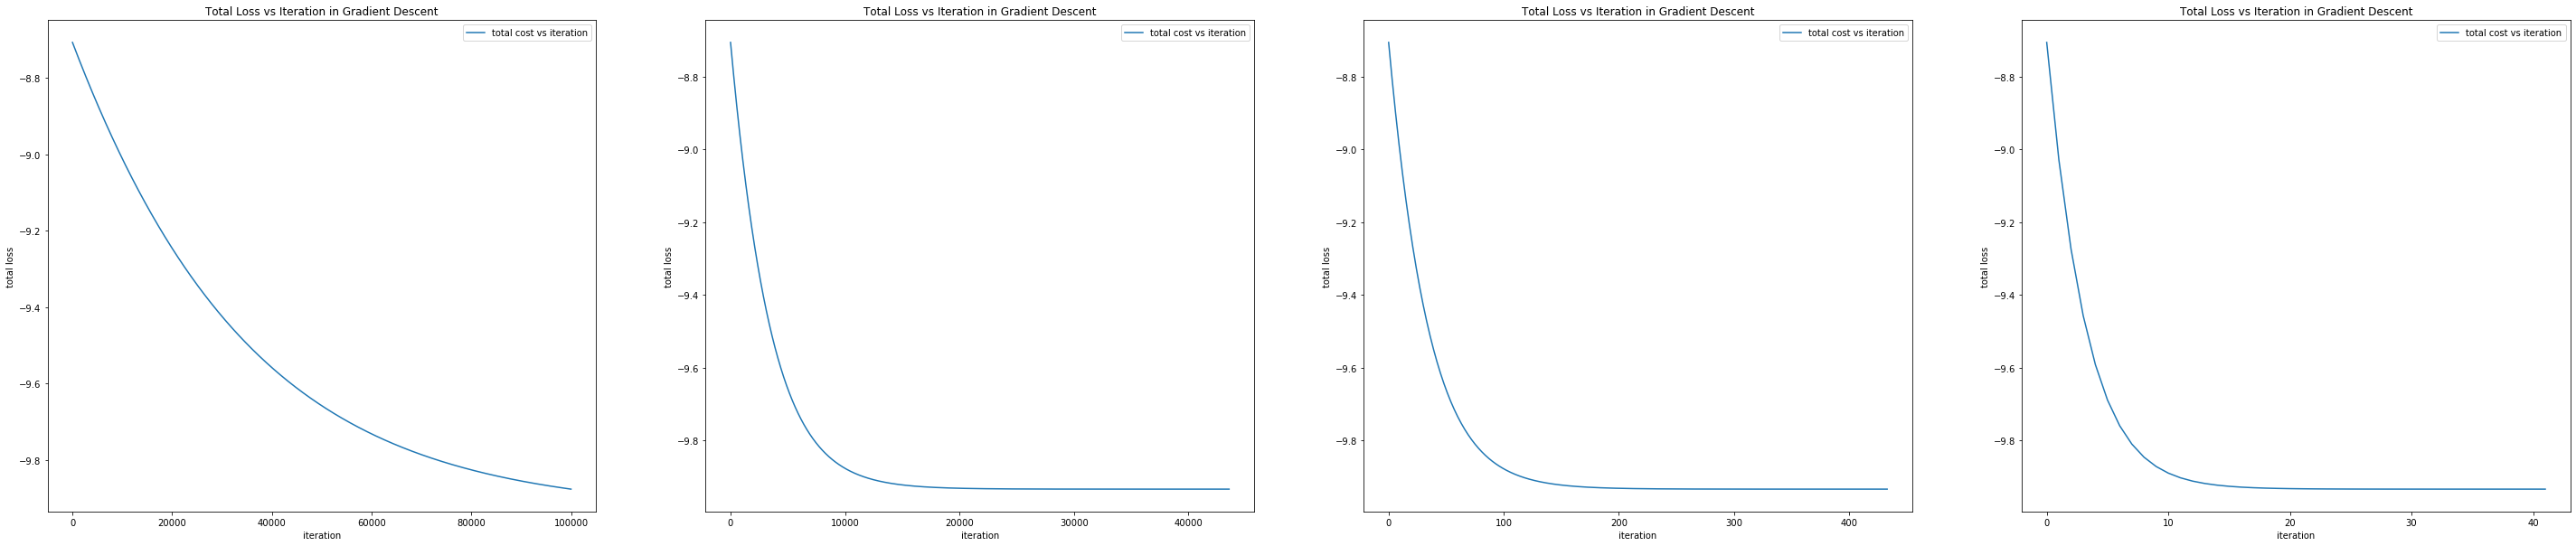

In [12]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

step_sizes = [0.1, 1., 100, 1000.]

fig, ax = plt.subplots(1, 4, figsize=(50, 10))

for i in range(len(step_sizes)):
    step_size = step_sizes[i]
    history, _ = gradient_descent(x, y, lambdas_init, step_size=step_size, maxsteps=100000)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)

    ax[i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('total loss')
    ax[i].set_title('Total Loss vs Iteration in Gradient Descent')
    ax[i].legend(loc='best')

plt.show()

It doesn't look like gradient descent is too sensitive to the step size (at least from the initialization we chose).

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
****************************
without initial random shuffling
****************************
stepsize:  0.1
time to compute one gradient:  0.00012302398681640625
how many iters:  128001
final loss: -9.934057010294472
precision to actual param: 0.00606677836337854


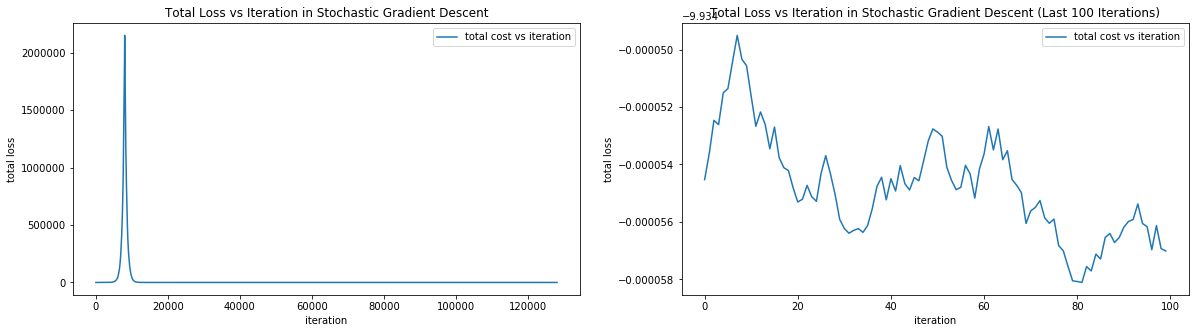

In [14]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

step_size = 0.1

history, epoch, _ = sgd(x, y, lambdas_init, init_shuffle=False, step_size=step_size, max_epochs=8)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print('****************************')
print('without initial random shuffling')
print('****************************')
print('stepsize: ', step_size)
print('time to compute one gradient: ', end - start)
print('how many iters: ', len(history))
print('final loss:', costs[-1])
print('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Stochastic Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Stochastic Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
****************************
with initial random shuffling
****************************
stepsize:  0.1
time to compute one gradient:  0.00014710426330566406
how many iters:  128001
final loss: -9.93384545405099
precision to actual param: 0.014227556507618484


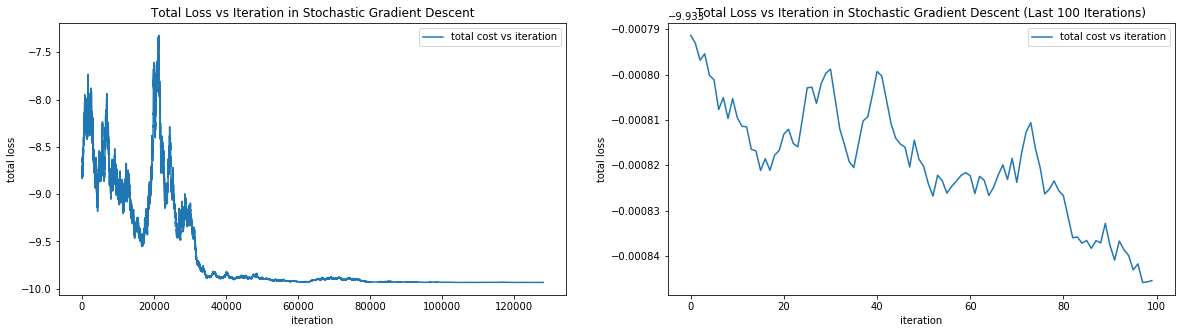

In [15]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

step_size = 0.1

history, epoch, _ = sgd(x, y, lambdas_init, init_shuffle=True, step_size=step_size, max_epochs=8)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print('****************************')
print('with initial random shuffling')
print('****************************')
print('stepsize: ', step_size)
print('time to compute one gradient: ', end - start)
print('how many iters: ', len(history))
print('final loss:', costs[-1])
print('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Stochastic Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Stochastic Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

epoch:  0
****************************
without initial random shuffling
****************************
stepsize:  1.0
time to compute one gradient:  0.00015020370483398438
how many iters:  15868
final loss: -9.934102852275833
precision to actual param: 0.0009584050556876609


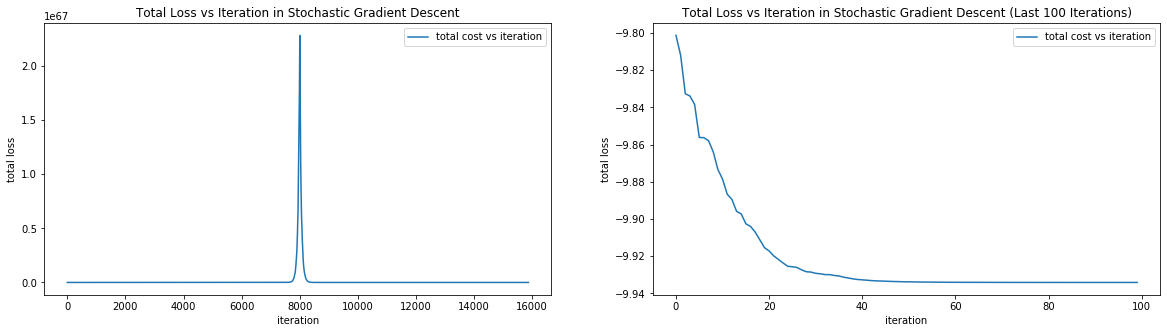

In [16]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

step_size = 1.

history, epoch, _ = sgd(x, y, lambdas_init, init_shuffle=False, step_size=step_size, max_epochs=8)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print('****************************')
print('without initial random shuffling')
print('****************************')
print('stepsize: ', step_size)
print('time to compute one gradient: ', end - start)
print('how many iters: ', len(history))
print('final loss:', costs[-1])
print('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Stochastic Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Stochastic Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

epoch:  0
****************************
with initial random shuffling
****************************
stepsize:  1.0
time to compute one gradient:  0.00020194053649902344
how many iters:  6990
final loss: -9.934102869181826
precision to actual param: 0.0009514755056730088


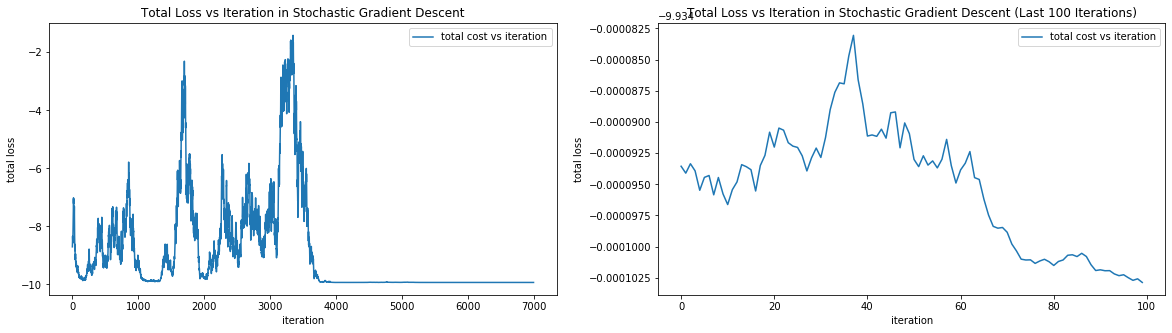

In [17]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

step_size = 1.

history, epoch, _ = sgd(x, y, lambdas_init, init_shuffle=True, step_size=step_size, max_epochs=8)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print('****************************')
print('with initial random shuffling')
print('****************************')
print('stepsize: ', step_size)
print('time to compute one gradient: ', end - start)
print('how many iters: ', len(history))
print('final loss:', costs[-1])
print('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Stochastic Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Stochastic Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

epoch:  0
****************************
without initial random shuffling
****************************
stepsize:  100.0
time to compute one gradient:  0.000125885009765625
how many iters:  541
final loss: inf
precision to actual param: inf


/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  


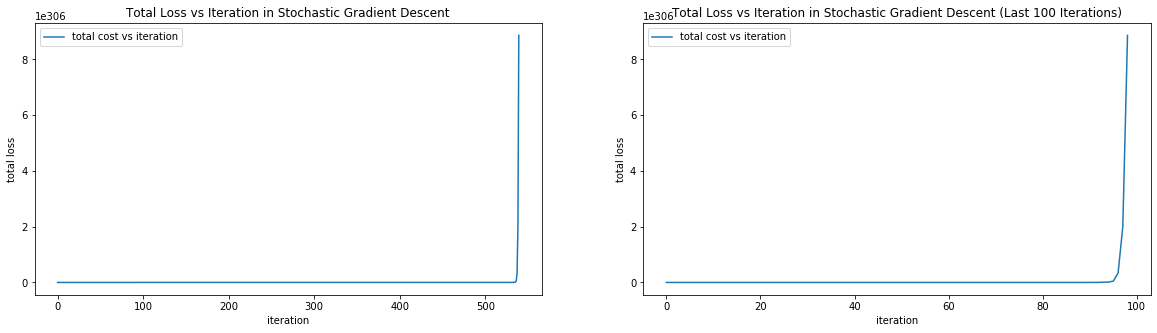

In [18]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

step_size = 100.

history, epoch, _ = sgd(x, y, lambdas_init, init_shuffle=False, step_size=step_size, max_epochs=8)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print('****************************')
print('without initial random shuffling')
print('****************************')
print('stepsize: ', step_size)
print('time to compute one gradient: ', end - start)
print('how many iters: ', len(history))
print('final loss:', costs[-1])
print('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Stochastic Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Stochastic Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

epoch:  0
****************************
with initial random shuffling
****************************
stepsize:  100.0
time to compute one gradient:  0.00012969970703125
how many iters:  9843
final loss: -9.934104005297604
precision to actual param: 9.847274567320596e-05


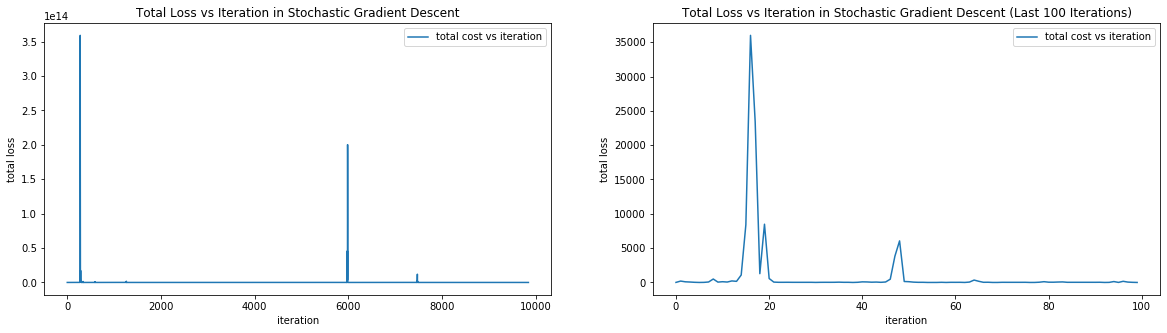

In [19]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

step_size = 100.

history, epoch, _ = sgd(x, y, lambdas_init, init_shuffle=True, step_size=step_size, max_epochs=8)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print('****************************')
print('with initial random shuffling')
print('****************************')
print('stepsize: ', step_size)
print('time to compute one gradient: ', end - start)
print('how many iters: ', len(history))
print('final loss:', costs[-1])
print('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Stochastic Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Stochastic Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

epoch:  0
****************************
with initial random shuffling
****************************
stepsize:  1000.0
time to compute one gradient:  0.00011610984802246094
how many iters:  185
final loss: inf
precision to actual param: inf


/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  


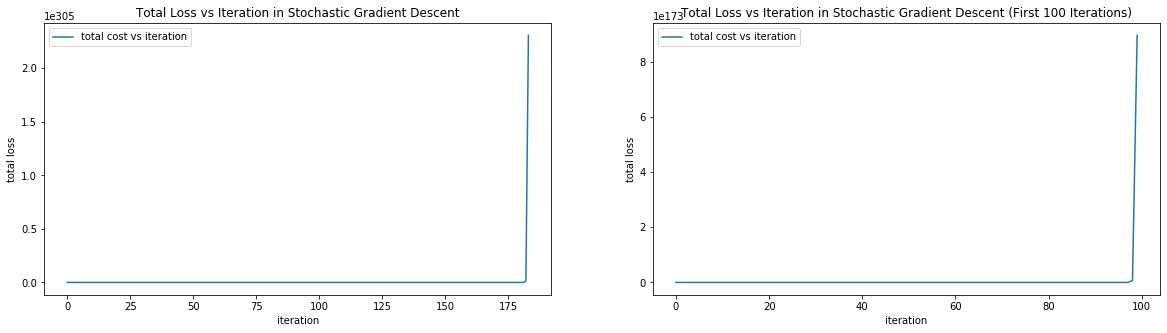

In [20]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

step_size = 1000.

history, epoch, _ = sgd(x, y, lambdas_init, init_shuffle=True, step_size=step_size, max_epochs=8)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print('****************************')
print('with initial random shuffling')
print('****************************')
print('stepsize: ', step_size)
print('time to compute one gradient: ', end - start)
print('how many iters: ', len(history))
print('final loss:', costs[-1])
print('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Stochastic Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[:100])), costs[:100], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Stochastic Gradient Descent (First 100 Iterations)')
ax2.legend(loc='best')
plt.show()

We see that if we don't shuffle the data initially, for step sizes 0.01 through 1, the stochastic gradient descent will follow a path heading away from the global optimum (increases the total loss along the path). Let this be a warning to us all: for some permutations of your data, your stochastic gradient descent can head away from your optimal solution and never return!

When we shuffle the data before beginning descent, we see that a step size of 0.01 sped up the convergence of SGD. That is, our algorithm converged upon the optimal solution in a mere 33 steps. This makes intuitive sense, the bigger your steps, the faster you reach your goal.

However, when the step size increased to 0.1, the algorithm now takes ***longer*** to converge (it required 59,412 iterations). Perhaps this is surprising to us. However, if we look once again at the path stochastic gradient descent takes through the parameter space, we can see the reason for the slow-down. Since SGD appears to read the global minimum by first climbing "up hill" (going in a direction that increases the total loss). Taking bigger steps here also means traveling further away from the goal and amplifying your errors in approximating the "true" gradient.

Finally, when the step size increases to 1. The total cost along the path that SGD takes in the parameter space is so large that it exceed machine precision.

The same experiments with gradient descent shows that SGD can be sensitive to changes in stepsizes in ways that gradient descent is not.

<a id='init'></a>
#### Sensitivity to Initialization
Why would your choice of initial parameters matter? Let's recall our visualization of the objective function:

<img src="fig/obj.png" style="height:350px;">

We see, from the above graphs, that our total loss function has three stationary points (points in the parameter space where the gradient of the total loss function is zero):

1. local and global minimum at approximately (2.05384, 0), with total loss -9.9341
2. local maximum at approximately (-2.47865, 0), with total loss 11.9546 
3. saddle point at approximately (-5.36325, 0), with total loss 8.16153 

At each of these points, since the gradient is very nearly zero, we'd expect gradient descent to be stationary (the algorithm will not make any updates to the parameters, since updates are proportional to the gradient vector). Thus, if gradient descent lands on either the local max or the saddle point during its path through the parameter space then it will not converge on the correct optimal value.

But how often can gradient descent get stuck at the local max or the saddle point? Since in every step of gradient descent, we update the parameter to decrease total loss, it is very unlikely that we will end up at the local max (if our initialization is not at the local max). On the other hand, if we are initialized on the left of the local max and along the straight line passing through the local max and the saddle point, then we are nearly guaranteed to land in the saddle point. The intuition is: if you initialize on the *right* side of the hill containing our local max, then we will "slide down" right into the global min, but if we initialize on the left side of the hill, then we will "slide down" into the saddle point.

Let's experiment with several initializations for gradient descent.

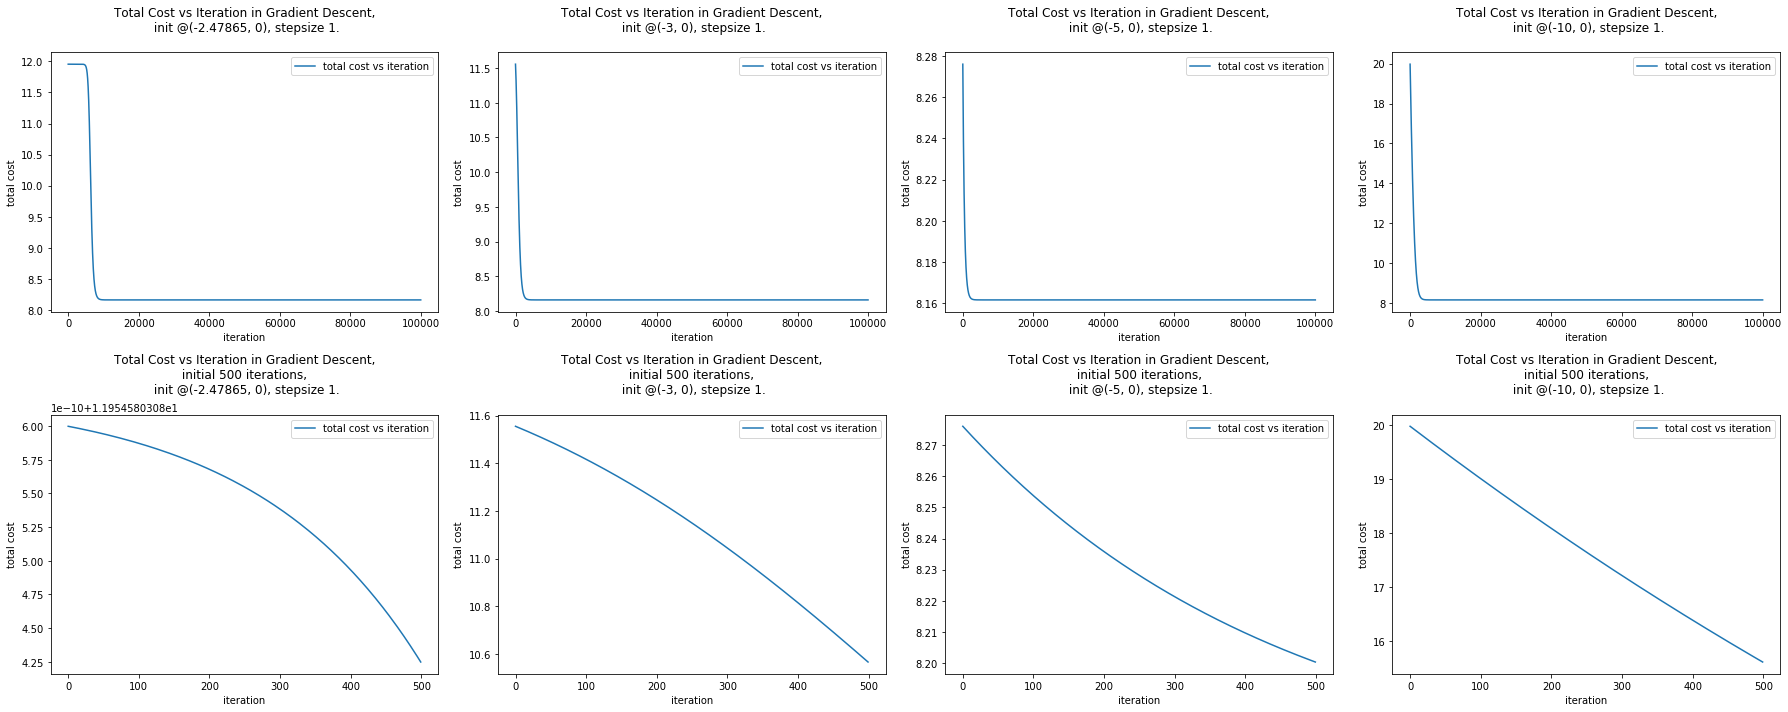

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(25, 10))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history, _ = gradient_descent(x, y, lambdas_inits[i], step_size=10., maxsteps=100000)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    ax[0, i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[0, i].set_xlabel('iteration')
    ax[0, i].set_ylabel('total cost')
    ax[0, i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 1.\n'.format(lambdas_inits[i][0]))
    ax[0, i].legend(loc='best')
    
    ax[1, i].plot(range(len(costs[:500])), costs[:500], label='total cost vs iteration')
    ax[1, i].set_xlabel('iteration')
    ax[1, i].set_ylabel('total cost')
    ax[1, i].set_title('Total Cost vs Iteration in Gradient Descent,\n initial 500 iterations, \n init @({}, 0), stepsize 1.\n'.format(lambdas_inits[i][0]))
    ax[1, i].legend(loc='best')
    
plt.tight_layout()
plt.show()

We see that in each case, for each initial choice of lambdas, gradient descent proceeded towards the saddle point and, once having reached the saddle, remained at the saddle.

What is unexpected is the behaviour of gradient descent for the initialization (-2.47865, 0). Recall that at $(\lambda_1, \lambda_2) = (-2.47865, 0)$, the total loss function has a local max and at a local max the gradient is zero. So why doesn't gradient descent get stuck at the local max? Well, it did, for about a couple of thousands of iterations (see left-most column of graphs above). But recall that we are approximating the location of the local max with $(-2.47865, 0)$, thus the gradient at $(-2.47865, 0)$ is close to zero but not exactly zero. This means that your gradient descent algorithm maybe making microscopic progress in the parameter space and that if you let it run for long enough, it might move to a region of the space where the gradients are large again. Note that, in practice, we never let gradient descent algorithms crawl! That is, we terminate the algorithm whenever it ceases to make "large" updates to the parameters. This is because for a general complex objective function there is not always a way for us to predict how long the algorithm must run before it gets "unstuck" or converges on an acceptable solution. 

In [22]:
print('gradient at approximate local max (-2.47865, 0):', grad(-2.47865, 0, x, y))
print('gradient at approximate saddle (-5.36325, 0):', grad(-5.36325, 0, x, y))

gradient at approximate local max (-2.47865, 0): [1.27466626e-05 0.00000000e+00]
gradient at approximate saddle (-5.36325, 0): [-1.27991562e-06  0.00000000e+00]


So how will stochastic gradient descent behave around stationary points (points at which the gradient of the total loss function is zero)? Recall that stochastic gradient descent does not compute the gradient of the "real" objective function in each iteration. Rather it computes an "approximate" gradient using just one data point (i.e. it compute the gradient of the loss function at just one random point). 

In lecture, we discussed how this descent with "approximate" gradients can be less efficient - while gradient descent beelines for the optimal solution, stochastic gradient descent can meander in the parameter space. However, the same "noisy" trajectories stochastic gradient descent can also help us avoid getting stuck in non-optimal stationary points. The intuition is simple, at places where the total loss function has zero gradient, it is possible that a random "approximate" loss function will not have zero gradient.

Let's experiment with stochastic gradient descent for the same set of initializations in the parameter space:

Final cost with initialization @ (-2.47865, 0) in 8 epochs is 11.95458030862372
Final cost with initialization @ (-3, 0) in 8 epochs is 11.954580308623719
Final cost with initialization @ (-5, 0) in 8 epochs is 8.161528699372983
Final cost with initialization @ (-10, 0) in 8 epochs is 8.161528699372983


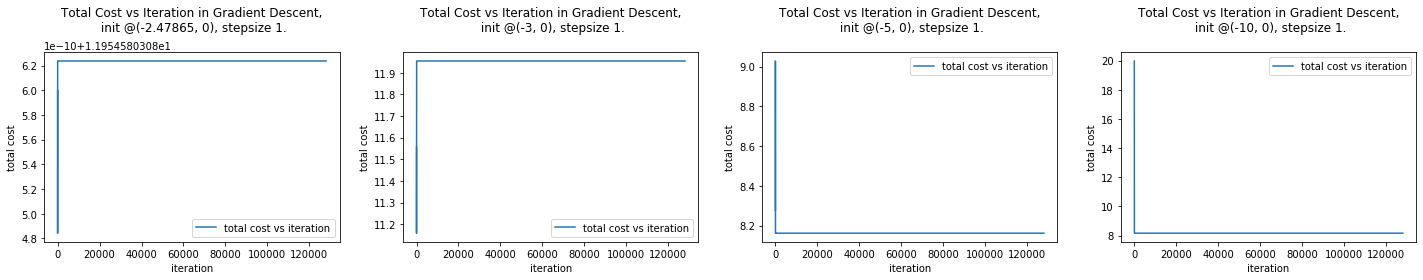

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history, epoch, _ = sgd(x, y, lambdas_inits[i], init_shuffle=True, step_size=10., max_epochs=8, output=False)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    print('Final cost with initialization @ ({}, {}) in {} epochs is {}'.format(lambdas_inits[i][0], lambdas_inits[i][1], epoch, costs[-1]))
    ax[i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('total cost')
    ax[i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 1.\n'.format(lambdas_inits[i][0]))
    ax[i].legend(loc='best')
    
plt.tight_layout()
plt.show()

We see that with step size 1., stochastic gradient descent appears to do no better than gradient descent in escaping stationary points! So is our intuition about stochastic descent wrong? Well, recall that stochastic descent is very sensitive to stepsize, in particular, the "stochastic-ness" (or randomness) of the algorithm can be either amplified or diminished by the step-size. Choose sufficiently small step sizes, you may not see too much randomness in the behaviour of your SGD; choose sufficiently large step sizes, you may observe very unexpected results.

Let's increase the step size to 50 and see what happens:

Final cost with initialization @ (-2.47865, 0) in 0 epochs is -9.934102003880689
Final cost with initialization @ (-3, 0) in 0 epochs is -9.93410328049225
Final cost with initialization @ (-5, 0) in 0 epochs is -9.934103749944729
Final cost with initialization @ (-10, 0) in 0 epochs is -9.934103944875742


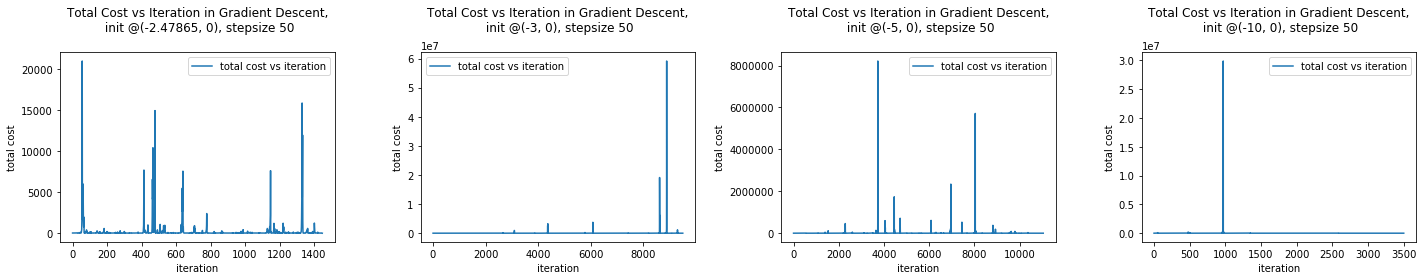

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history, epoch, _ = sgd(x, y, lambdas_inits[i], init_shuffle=True, step_size=50, max_epochs=8, output=False)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    print('Final cost with initialization @ ({}, {}) in {} epochs is {}'.format(lambdas_inits[i][0], lambdas_inits[i][1], epoch, costs[-1]))
    ax[i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('total cost')
    ax[i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 50\n'.format(lambdas_inits[i][0]))
    ax[i].legend(loc='best')
    
plt.tight_layout()
plt.show()

So in this case, we see that SGD is able to converge onto the correct optimum for all initial values of lambdas we chose! With an increase in the step size, we were able to amplify the randomness of the algorithm enough to help us escape stationary points! 

Now, this begs the question:

**What step size should I choose to help SGD escape undesirable stationary points?**

For example, is it true that the bigger the step-size the faster my SGD algorithm converges onto the global minimum? Let's run SGD on the same set of initial lambda values again, this time, with step size 500.

/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/anaconda3/envs/am207/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  


Final cost with initialization @ (-2.47865, 0) in 0 epochs is inf
Final cost with initialization @ (-3, 0) in 0 epochs is inf
Final cost with initialization @ (-5, 0) in 0 epochs is inf
Final cost with initialization @ (-10, 0) in 0 epochs is inf


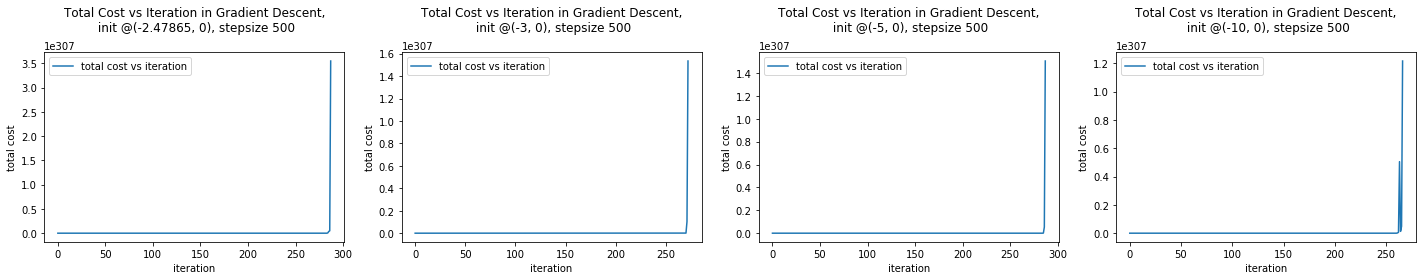

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history, epoch, _ = sgd(x, y, lambdas_inits[i], init_shuffle=True, step_size=500, max_epochs=8, output=False)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    print('Final cost with initialization @ ({}, {}) in {} epochs is {}'.format(lambdas_inits[i][0], lambdas_inits[i][1], epoch, costs[-1]))
    ax[i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('total cost')
    ax[i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 500\n'.format(lambdas_inits[i][0]))
    ax[i].legend(loc='best')
    
plt.tight_layout()
plt.show()

Just as we saw before, when the step size is "large", stochastic gradient descent can have unexpected and deeply undesirable behaviours (for contrast, run gradient descent using a stepsize of 500).

### Lesson Learned:
Unlike gradient descent, which can get stuck in undesirable stationary points, the randomness of stochastic gradient descent can keep the algorithm moving towards the global optimum. But this benefit can only be realized by the correct choice of step size, for a choice of step size that is too small, the randomness of SGD (with fixed step size) is insufficient to move it out of a stationary point; for a choice of step size that is too large, the randomness of SGD (with fixed step size) may prevent the algorithm from converging or even getting close to the global optimum.

### Part II: Simulated Annealing
1. Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our lost function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

  For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should feel free to set your own):

  - Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
  - Min Length: 500
  - Max Temperature: 10

  You should set your own cooling schedule.
  
  
**Solutions:**

To perform simulated annealing, we just need the following ingredients:

1. an objective function, this will be our total loss function $L$
2. a proposal function, $g$ (satisfying some technical conditions)
3. a heatin/cooling schedule
4. hyperparameter settings: maximum temperature, minimum chain length at each temperature


Since our total loss function is a real-valued function in two variables ($\lambda_1$ and $\lambda_2$), we need our proposal function $g(\lambda^{new}_1, \lambda^{new}_2 | \lambda^{old}_1, \lambda^{old}_2)$ to also be a bivariate function. To keep things simple, let's choose
$$
g(\lambda^{new}_1, \lambda^{new}_2 | \lambda^{old}_1, \lambda^{old}_2) = \mathcal{N}(\lambda^{new}_1, \lambda^{new}_2; [\lambda^{old}_1, \lambda^{old}_2], \Sigma),
$$
that is, the proposal function is a normal pdf centered at the current values of lambda with covariance matrix $\Sigma$. In our case, we will set $\Sigma = \left(\begin{array}{cc} 1& 0\\ 0& 1 \end{array}\right)$

We will run the algorithm for 10 epochs, each time cooling the current temperature by 80%. At each temperature, we will let the algorithm run for 120% longer than at the previous, higher, temperature (running the algo longer at cooler temperatures will encourage convergences).

In [27]:
#Simulated Annealing
def sa(energy, init_params, epochs, reduce_temp, incr_iters, proposal):
    accumulator = []
    
    old_solution = init_params['solution']
    old_energy = energy(old_solution)
    
    temp = init_params['max_temp']
    length = init_params['min_length']
    
    accepted=0
    total=0
    
    for epoch in range(epochs):
        #print "Epoch:", epoch
        
        #decrease temperature and increase iteration length
        if epoch > 0:
            temp = reduce_temp(temp)
            length = incr_iters(length)
            
        #print "Temperature", temp, "Length", length

        for it in range(length):
            total += 1
            
            #propose new solution based on current solution
            new_solution = proposal(old_solution)
            #compute energy of new solution
            new_energy = energy(new_solution)
            
            #compute a probability for accpeting new solution
            alpha = min(1, np.exp((old_energy - new_energy) / temp))
            
            #if new solution is better, i.e. gives us lower energy, then accept
            #if new solution is not better, we flip a weighted coin and decide whether to accept
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)): 
                accepted += 1
                accumulator.append([temp, new_solution, new_energy])
                
                old_energy = new_energy
                old_solution = new_solution
                
            else:
                # Keep the old stuff
                accumulator.append([temp, old_solution, old_energy])

    return accumulator, accepted * 1. / total

In [28]:
#Proposal distribution: bivariate normal with 
Sigma = [[1, 0], [0, 1]]
proposal = lambda x: np.random.multivariate_normal(x, Sigma, 1)[0]

reduce_temp = lambda t: 0.8*t #temperature function
incr_iters = lambda length: int(math.ceil(1.2*length)) #iteration function

energy = lambda l: L(l[0], l[1], x, y)

In [29]:
lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for lambdas in lambdas_inits:
    init_params = {'solution':np.array(lambdas), 'min_length':500, 'max_temp':10}
    accumulator, accepted_ratio = sa(energy, init_params, 10, reduce_temp, incr_iters, proposal)
    print('\n******** Results for init @ ({}, {})********'.format(lambdas[1], lambdas[0]))
    print('ratio of solutions accepted: ', accepted_ratio)
    accumulator_sorted = sorted(accumulator, key=lambda t: t[2])
    print('we found the minimum of {} with parameters ({}, {}), at temperature {}'.format(accumulator_sorted[0][2], accumulator_sorted[0][1][0], accumulator_sorted[0][1][1], accumulator_sorted[0][0]))


******** Results for init @ (0, -2.47865)********
ratio of solutions accepted:  0.5600554357868802
we found the minimum of -9.933714512915854 with parameters (2.0613637514567795, -0.01390530503117321), at temperature 2.621440000000001

******** Results for init @ (0, -3)********
ratio of solutions accepted:  0.5574376347397598
we found the minimum of -9.933510997339557 with parameters (2.0569515631468103, -0.021098810852191868), at temperature 1.3421772800000007

******** Results for init @ (0, -5)********
ratio of solutions accepted:  0.5541268863566369
we found the minimum of -9.934085886172213 with parameters (2.0546268904680556, -0.003606147251318137), at temperature 1.3421772800000007

******** Results for init @ (0, -10)********
ratio of solutions accepted:  0.5668309208500154
we found the minimum of -9.932637552487444 with parameters (2.0488712660031005, -0.033158102441044945), at temperature 1.3421772800000007


**Conclusion:** From the above we see that, with Simulated Annealing, we were able to converge around the correct global minimum for all the initial values of lambdas that caused problems for gradient descent (and for stochastic gradient descent, up to a point).